In [1]:
%load_ext autoreload
%autoreload 2

## Import modules and packages

In [2]:
import sys

sys.path.append("../../src")
import stochastic_benchmark as SB
import numpy as np
import os
import bootstrap
import interpolate
import stats
from utils_ws import *
import pickle

## Creating a `stochastic_benchmark` object
The primary class we will use is the `stochastic_benchmark` class in the `stochastic_benchmark` module. 
Run the cell below to instantiate it.

In [3]:
here = os.getcwd()
parameter_names = [
    "iterations",
    "shots",
    "rounds",
]  # think about whether iterations should be a parameter or not.
instance_cols = [
    "instance"
]  # indicates how instances should be grouped, default is ['instance']

## Response information
response_key = "approx_ratio"  # Column with the response
response_dir = 1  # whether we want to maximize (1) or minimize (-1), default is 1

## Optimizations informations
recover = True  # Whether we want to read dataframes when available, default is True
reduce_mem = True  # Whether we want to segment bootstrapping and interpolation to reduce memory usage, default is True
smooth = True  # Whether virtual best should be monontonized, default is True

sb = SB.stochastic_benchmark(
    parameter_names=parameter_names,
    here=here,
    instance_cols=instance_cols,
    response_key=response_key,
    response_dir=response_dir,
    smooth=smooth,
)

## Load Bootstrap data
The cell below can be used to generate bootstrapped data from raw data. In this demo however, bootstrapped data for 10 problem instances is already stored in the `checkpoints` folder. Running the cell below will load that data into memory.

In [4]:
# Load Bootstrap data.
# The data is already boostrapped, but needs to be loaded into memory
shared_args = {
    "response_col": "approx_ratio",
    "resource_col": "resource",
    "response_dir": 1,
    "confidence_level": 68,
}
boots_range = [1, 2, 5, 10, 20, 50, 100]
bsParams = bootstrap.BootstrapParameters(
    shared_args=shared_args, update_rule=lambda df: None
)
bs_iter_class = bootstrap.BSParams_range_iter()
bsParams_iter = bs_iter_class(bsParams, boots_range)
sb.run_Bootstrap(bsParams_iter)

## Interpolation
The data from each instance might be available at different values of resource. Using interpolation, obtain estimates for the performance and parameters at the same grid of resource values for each instance. 

To that end, it is necessary to define a notion of the amount of resources used for each run. In the iterative QAOA, a reasonable measure of the amount of resources used is the number of times the quantum hardware was accessed. That is, we define the amount of resources to be equal to the product of the number of shots, the number of restarts (called `boots` in the bootstrap `pkl` data), and the number of minimizer iterations, COBYLA for this demo. The resource calculation should be specified as a function (`resource_fun` in the cell below), which will then be passed to the interpolation method. Other ways of defining the resource are also valid (for example, in terms of the amount of QPU time), but we use the function below for this demo.

The results of the interpolation for all instances are stored in a single file- `checkpoints/interpolated_results.pkl`, and are loaded into memory in the form of a dataframe that can be accessed using `sb.interp_results`.

In [5]:
# Interpolate
def resource_fcn(df):
    return df["boots"] * df["iterations"] * df["shots"]


iParams = interpolate.InterpolationParameters(resource_fcn, parameters=parameter_names)
sb.run_Interpolate(iParams)

100%|██████████| 540/540 [00:00<00:00, 816.02it/s]


## Split the data into test and train instances
If `train_test_split=0.8`, $80\%$ of the instances will be labeled as train instances, while the remaining will form the test data.
The `run_Stats` method will implement this splitting, adding a column called `train` to `sb.interp_results`. The updated dataframe is also stored in `checkpoints/interpolated_results.pkl`.

In addition, `run_Stats` computes various statistics for the test and train sets separately and stores the data in the form of dataframes, in `checkpoints/testng_stats.pkl` and `checkpoints/training_stats.pkl` respectively. They are also stored in memory and can be accessed as `sb.testing_stats` and `sb.training_stats`. The statistic of interest can be specified by instantiating `stats.StatsParameters` appropriately. For this demo, we prefer to compute the median, $75\%$ quantile and the $25\%$ quantile for the response (the approximation ratio). One may instead choose to compute the mean and the $68\%$ confidence interval (assuming a gaussian distribution).

In [6]:
# Set up Stats computations
train_test_split = 0.8
metrics = ["approx_ratio"]
stParams = stats.StatsParameters(metrics=metrics, stats_measures=[stats.Median()])
sb.run_Stats(stParams, train_test_split)

100%|██████████| 20895/20895 [00:01<00:00, 10567.55it/s]


## Obtain the virtual best baseline
For the testing set, the cell below computes the best performance and parameters observed for the testing instance. The output is stored in `checkpoints/VirtualBest_test.pkl` and also in working memory (`sb.baseline.rec_params`).


In [7]:
sb.run_baseline()

## Projection Experiments
Descriptions to be added soon

In [8]:
sb.run_ProjectionExperiment("TrainingStats", None, None)
sb.run_ProjectionExperiment("TrainingResults", None, None)

## Plot the performance and parameters

In [9]:
import plotting

plotting.monotone = True
sb.initPlotting()

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 2535.81it/s]


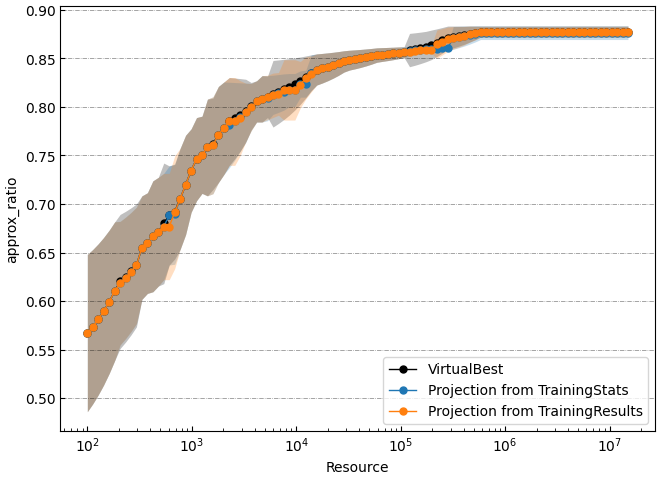

In [10]:
fig, axs = sb.plots.plot_performance()
fig.savefig("performance.png")

100%|██████████| 100/100 [00:00<00:00, 2409.18it/s]

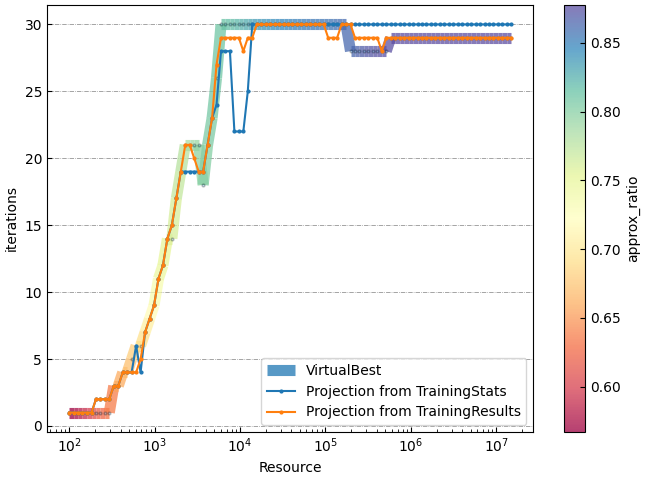

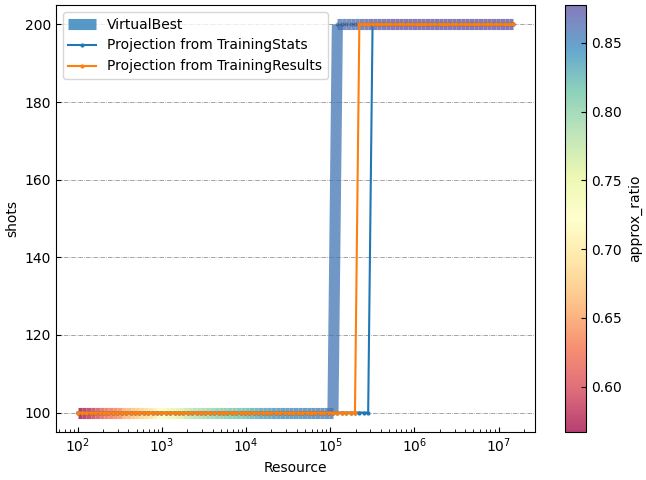

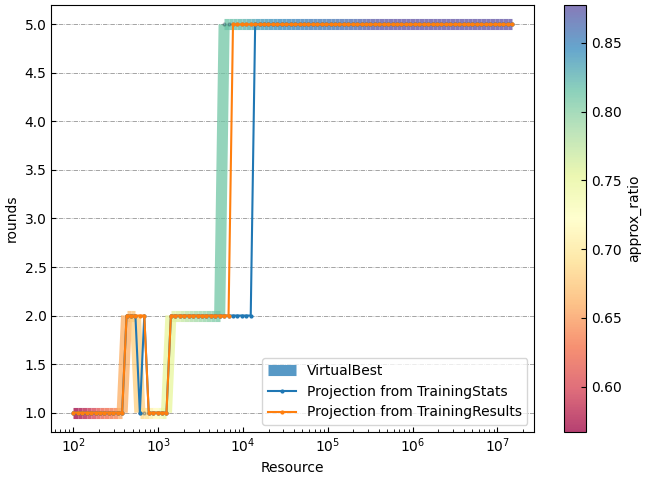

In [11]:
figs, axes = sb.plots.plot_parameters_separate()
for param, fig in figs.items():
    fig.savefig(param + ".png")

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 2370.73it/s]


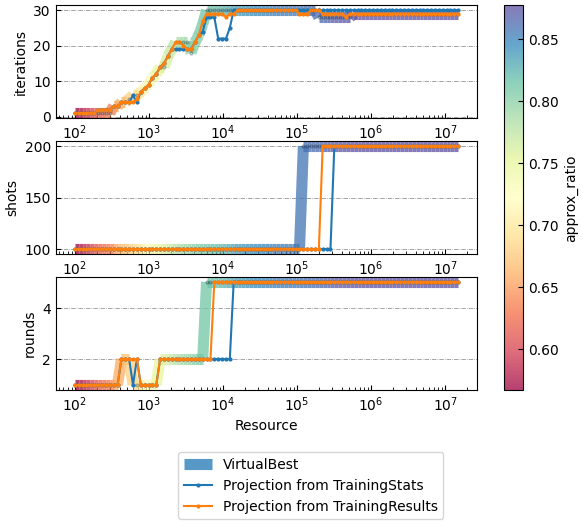

In [12]:
fig, axes = sb.plots.plot_parameters_together()
fig.savefig("all_params.png")